# segmetaion to binary masks

In [72]:
json_file = 'tiny/labels/modanet_snaps.json'
df = pd.read_json(json_file)
df

,file_name,height,id,image_id,image_url,items,license,path,width
0,0115261.jpg,600,115261,115261,http://images0.chictopia.com/photos/ChloroformPerfume/7608775449/8529098849/8529098849_400.jpg,"[{'area': 5335, 'bbox': [88, 350, 55, 97], 'category_id': 5, 'id': 13483, 'iscrowd': 0, 'segmentation': [[153, 483, 165, 488, 171, 493, 178, 487, 193, 487, 197, 484, 191, 478, 184, 474, 186, 451, 189, 442, 198, 462, 205, 474, 205, 467, 201, 452, 197, 439, 200, 441, 207, 453, 211, 468, 220, 478, 225, 481, 236, 473, 245, 466, 239, 457, 241, 454, 238, 444, 233, 437, 227, 429, 222, 417, 216, 411, 216, 406, 216, 386, 216, 400, 231, 407, 234, 409, 248, 407, 266, 400, 277, 396, 290, 386, 295, 383, 299, 379, 294, 374, 291, 366, 284, 367, 279, 371, 261, 377, 241, 380, 227, 370, 213, 360, 207, 366, 199, 363, 190, 352, 178, 344, 182, 366, 185, 382, 181, 385, 163, 369, 151, 358, 148, 356, 148, 349, 135, 339, 131, 345, 132, 360, 151, 384, 156, 384, 160, 397, 159, 404, 155, 427, 154, 458, 153, 474], [143, 386, 127, 365, 118, 353, 110, 350, 100, 355, 96, 365, 88, 381, 89, 380, 91, 405, 92, 427, 95, 439, 102, 444, 110, 447, 122, 440, 135, 433, 139, 424, 128, 415, 129, 410, 136, 408, 140, 405, 140,...",3,/photos/ChloroformPerfume/7608775449/8529098849/8529098849_400.jpg,400
1,0277920.jpg,600,277920,277920,http://images0.chictopia.com/photos/RJanine/7601727358/dark-brown-sunglasses-orange-indian-bracelet-mustard-mendrez-wedges_400.jpg,"[{'area': 2014, 'bbox': [196, 546, 38, 53], 'category_id': 4, 'id': 41511, 'iscrowd': 0, 'segmentation': [[122, 527, 123, 536, 126, 542, 134, 545, 139, 545, 143, 543, 146, 537, 148, 547, 149, 552, 152, 556, 152, 571, 151, 573, 146, 571, 141, 571, 136, 571, 131, 573, 125, 578, 130, 583, 136, 585, 143, 587, 146, 586, 148, 585, 146, 590, 142, 591, 136, 590, 131, 588, 125, 583, 119, 574, 119, 565, 117, 558, 117, 550, 117, 543, 118, 536, 119, 531], [201, 585, 209, 584, 216, 585, 222, 589, 224, 594, 209, 594, 203, 594, 196, 594, 199, 599, 209, 599, 220, 599, 228, 599, 234, 586, 234, 576, 233, 567, 234, 555, 232, 553, 231, 550, 229, 546, 228, 555, 217, 554, 211, 554, 206, 554, 204, 558, 203, 563, 201, 571, 201, 576, 198, 583]]}, {'area': 43512, 'bbox': [121, 252, 147, 296], 'category_id': 8, 'id': 41512, 'iscrowd': 0, 'segmentation': [[178, 265, 190, 268, 204, 268, 220, 266, 232, 264, 240, 261, 248, 256, 253, 252, 258, 266, 262, 276, 266, 293, 268, 314, 263, 343, 258, 356, 255, 372, 252, ...",3,/photos/RJanine/7601727358/dark-brown-sunglasses-orange-indian-bracelet-mustard-mendrez-wedges_400.jpg,400
2,0169031.jpg,600,169031,169031,http://images0.chictopia.com/photos/GirlOnAVine/6061847158/4867956222/black-girlonavine-dress_400.jpg,"[{'area': 288, 'bbox': [166, 554, 12, 24], 'category_id': 4, 'id': 86807, 'iscrowd': 0, 'segmentation': [[191, 508, 212, 516, 214, 510, 204, 504, 191, 501], [208, 518, 211, 522, 207, 533, 207, 543, 204, 548, 206, 559, 205, 565, 198, 554, 195, 557, 206, 572, 203, 573, 200, 588, 180, 589, 176, 587, 174, 574, 178, 574, 200, 576, 202, 572, 191, 562, 176, 568, 176, 565, 184, 557, 180, 552, 185, 522, 190, 533, 206, 523], [179, 497, 180, 507, 175, 510, 165, 510, 157, 509, 159, 500, 162, 501, 165, 502, 170, 502, 173, 502, 176, 500], [185, 521, 180, 551, 175, 548, 163, 558, 163, 563, 163, 539, 156, 524, 160, 511, 164, 519, 174, 526, 180, 529], [178, 554, 173, 572, 173, 578, 168, 575, 166, 564, 166, 559, 170, 565, 174, 558]]}, {'area': 30384, 'bbox': [118, 101, 144, 211], 'category_id': 5, 'id': 86808, 'iscrowd': 0, 'segmentation': [[226, 120, 237, 124, 247, 132, 251, 142, 245, 151, 243, 157, 230, 166, 226, 178, 226, 188, 222, 199, 226, 208, 235, 221, 240, 223, 255, 245, 262, 256, 246, 266, ...",3,/photos/GirlOnAVine/6061847158/4867956222/black-girlonavine-dress_400.jpg,400
3,0381228.jpg,600,381228,381228,http://images0.chictopia.com/photos/CastawayVintage/4575599630/7635758647/black-vintage-jumper-black-obey-hat-black-forever-21-sunglasses-black-poll_400.jpg,"[{'area': 48688, 'bbox': [118, 140, 136, 358], 'categ

In [87]:
from pycocotools.coco import maskUtils

def annToRLE(segm, w, h):
    """
    Reference:
        https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
        
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    if type(segm) == list:
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, h, w)
        rle = maskUtils.merge(rles)
    elif type(segm['counts']) == list:
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = segm
    return rle

def annToMask(segm, w, h):
    """
    Reference:
        https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
    """
    rle = annToRLE(segm, w, h)
    m = maskUtils.decode(rle)
    return m

In [116]:
ctg_csv_file = os.path.join(
    os.environ['DATASET_ROOT'],
    'tiny/labels/master_category.csv'
)
df_ctgs = pd.read_csv(ctg_csv_file).set_index('category_id')
df_ctgs

,category
category_id,
1,bag
2,belt
3,boots
4,footwear
5,coat/jacket/suit/blazers/cardigan/sweater/Jumpsuits/Rompers/vest
6,dress/t-shir dress
7,sunglasses
8,pants/jeans/leggings
9,top/blouse/t-shirt/shirt


In [152]:
def mask_to_label(masks, class_ids):
    """
    Args:
        masks (np.array: (R, H, W))
        class_ids (np.array: (R,))
        
    Returns:
        label (np.array: (H, W))
    """
    label = masks * class_ids[:, None, None]
    y_dup, x_dup = np.where(np.sum(label != 0, axis=0) >= 2)
    label[:, y_dup, x_dup] = 0
    label = label.sum(axis=0)
    label -= 1 # set background class to -1
    return label

In [ ]:
img_dir = os.path.join(
    os.environ['DATASET_ROOT'],
    'tiny/images'
)

def read_img(filename):
    img_file = os.path.join(
        img_dir, filename
    )
    pil_img = Image.open(img_file).convert('RGB')
    img = np.array(pil_img).transpose(2, 0, 1)
    return img
   

(3, 600, 400)

(5, 600, 400)

array([ 2, 11,  9,  7,  4])

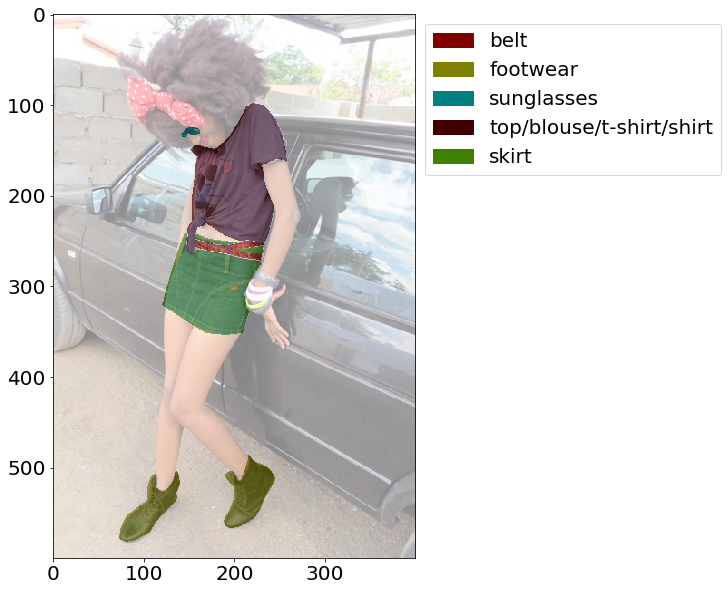

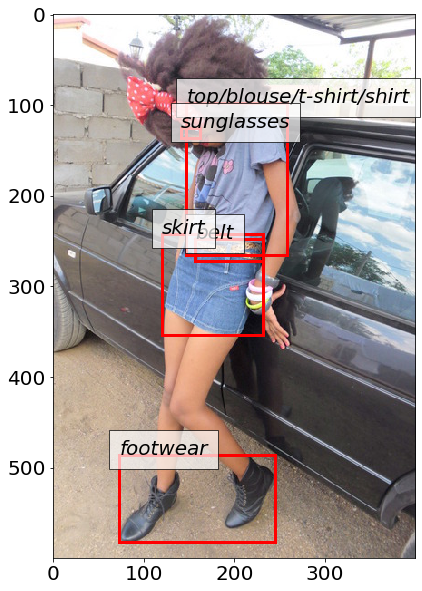

In [167]:
snap = df.iloc[5]
items = snap['items']
h = snap['height']
w = snap['width']
img = read_img(snap['file_name'])
img.shape


masks = np.array([
    annToMask(item['segmentation'], w, h)
    for item in items
])

category_ids = np.array([
    item['category_id']
    for item in items
])

masks.shape
category_ids


from chainercv.visualizations import vis_semantic_segmentation

ax, lenged_handles = vis_semantic_segmentation(
                        img, mask_to_label(masks, category_ids),
                        label_names=df_ctgs['category'].tolist(),
                        ignore_label_color=(255,255,255),
                        alpha=0.5,
                        all_label_names_in_legend=True)
_ = ax.legend(handles=lenged_handles,
          bbox_to_anchor=(1,1), loc=2)


from chainercv.utils import mask_to_bbox
from chainercv.visualizations import vis_bbox

bboxes = mask_to_bbox(masks)
_ = vis_bbox(
    img, bboxes, category_ids-1,
    label_names=df_ctg['category'].tolist()
)